In [2]:
import json
import geopandas as gp
from shapely.geometry import Polygon, Point, shape
from shapely.ops import transform
import pyproj
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
# from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.preprocessing import StandardScaler
%matplotlib inline 

In [3]:
# Limiting agricultural yield data to CORN and SOYBEAN crops

soybean = pd.read_csv("soybean-data.csv")
corn = pd.read_csv("corn-data.csv")
fires = pd.read_csv("omaha_fires.csv")
smoke_estimates = pd.read_csv("smoke_estimates.csv")

In [4]:
soybean_pivoted = soybean.pivot(index="Year", columns="Data Item",values='Value')
soybean_yield = soybean_pivoted.reset_index()[["Year","SOYBEANS - YIELD, MEASURED IN BU / ACRE"]].rename(columns={"SOYBEANS - YIELD, MEASURED IN BU / ACRE":"Yield (bushels/acre)"})

In [5]:
soybean_yield.head(2)

Data Item,Year,Yield (bushels/acre)
0,1960,33.0
1,1961,26.0


In [6]:
corn_pivoted = corn.pivot(index="Year", columns="Data Item",values='Value')[["CORN, GRAIN - YIELD, MEASURED IN BU / ACRE","CORN, GRAIN, IRRIGATED - YIELD, MEASURED IN BU / ACRE","CORN, GRAIN, NON-IRRIGATED - YIELD, MEASURED IN BU / ACRE"]]
corn_yield = corn_pivoted.reset_index()[["Year","CORN, GRAIN - YIELD, MEASURED IN BU / ACRE"]].rename(columns={"CORN, GRAIN - YIELD, MEASURED IN BU / ACRE":"Yield (bushels/acre)"})

In [7]:
corn_yield.head(2)

Data Item,Year,Yield (bushels/acre)
0,1910,38.3
1,1911,26.6


In [8]:
agri_data = soybean_yield.merge(corn_yield, on='Year').rename(columns = {"Yield (bushels/acre)_x":"Soybean_yield", "Yield (bushels/acre)_y":"Corn_yield"})

In [9]:
fires_new = fires.groupby('Fire_Year').agg(
                       total_GIS_Acres=('GIS_Acres', 'sum'),
                       number_of_fires=('GIS_Acres', 'count')
                   )

In [10]:
fiyah = fires_new.merge(smoke_estimates, on='Fire_Year').drop(columns=['smoke_estimate_dur', "log_smoke_estimate_dur"])

In [11]:
fiyah.columns

Index(['Fire_Year', 'total_GIS_Acres', 'number_of_fires', 'smoke_estimate',
       'log_smoke_estimate'],
      dtype='object')

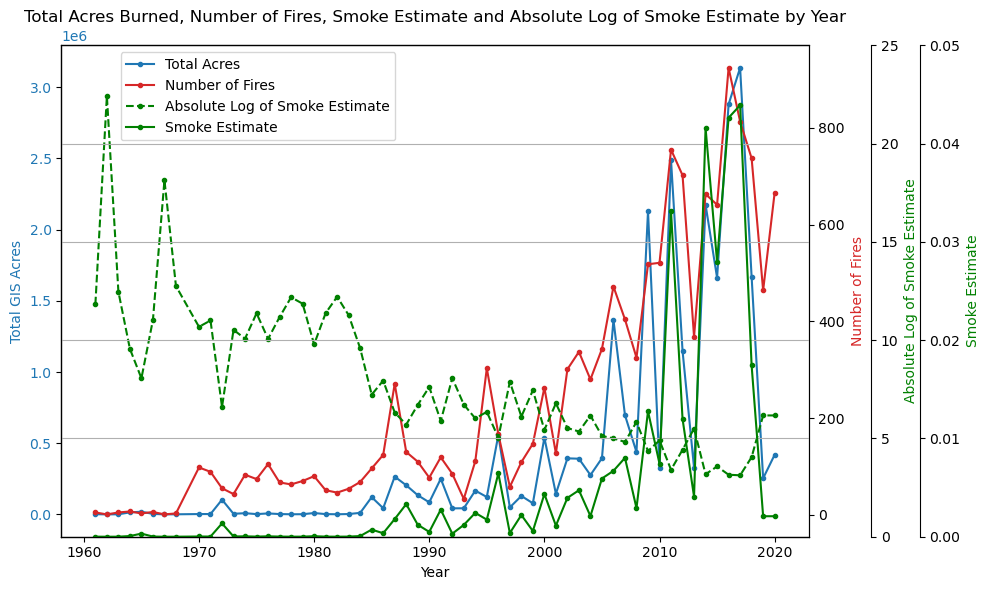

In [12]:
# Modified plot to include all 3 lines using Claude 3.5 Sonnet
# Prompt: "How can I ensure the log line is visible and clear on the plot"

# Create figure and axis objects with a single subplot
fig, ax1 = plt.subplots(figsize=(10,6))

# Plot total GIS acres on primary y-axis (blue solid line with dots)
color1 = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Total GIS Acres', color=color1)
ax1.plot(fiyah['Fire_Year'], fiyah['total_GIS_Acres'], color=color1, marker='o', label='Total Acres', markersize=3)
ax1.tick_params(axis='y', labelcolor=color1)

# Create second y-axis that shares the same x-axis
ax2 = ax1.twinx()
# Create third y-axis
ax3 = ax1.twinx()
ax4 = ax1.twinx()
# Move it to the right of the second axis
ax3.spines['right'].set_position(('outward', 45))
ax4.spines['right'].set_position(('outward', 80))

# Plot number of fires (red dashed line)
color2 = 'tab:red'
ax2.set_ylabel('Number of Fires', color=color2)
ax2.plot(fiyah['Fire_Year'], fiyah['number_of_fires'], color=color2, marker='o', markersize=3,
         linestyle='-', label='Number of Fires')

# Plot log smoke estimate on its own axis
ax3.set_ylabel('Absolute Log of Smoke Estimate', color='green')
ax3.plot(fiyah['Fire_Year'],fiyah['log_smoke_estimate'], 
         color='green', linestyle='--', label='Absolute Log of Smoke Estimate', marker='o', markersize=3)
ax3.set_ylim(0, 25)  # Based on the range shown in the bottom graph

ax4.set_ylabel('Smoke Estimate', color='green')
ax4.plot(fiyah['Fire_Year'],fiyah['smoke_estimate'], 
         color='green', linestyle='-', label='Smoke Estimate',marker='o', markersize=3)
ax4.set_ylim(0, 0.05)  # Based on the range shown in the bottom graph

# Add title and adjust layout
plt.title('Total Acres Burned, Number of Fires, Smoke Estimate and Absolute Log of Smoke Estimate by Year')
plt.grid(True)

# Add legend combining all lines
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
lines4, labels4 = ax4.get_legend_handles_labels()
ax2.legend(lines1 + lines2 + lines3 + lines4, labels1 + labels2 + labels3 + labels4, loc="upper left", bbox_to_anchor=(0.07, 1))

fig.tight_layout()
plt.show()

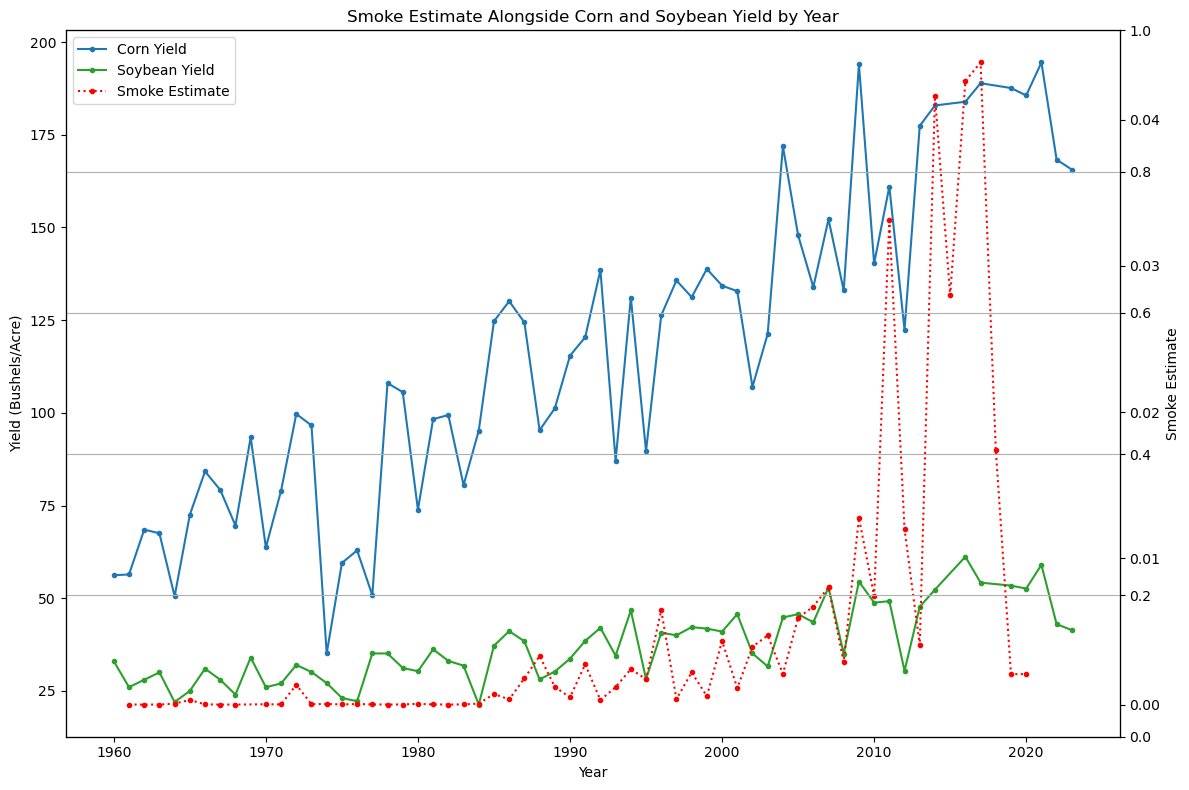

In [13]:
# Create figure and axis objects with a single subplot
fig, ax1 = plt.subplots(figsize=(12,8))

# Plot total GIS acres on primary y-axis (blue solid line with dots)
color1 = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Yield (Bushels/Acre)')
ax1.plot(agri_data['Year'], agri_data['Corn_yield'], color=color1, marker='o',markersize=3, label='Corn Yield')
ax1.tick_params(axis='y')

# # Create second y-axis that shares the same x-axis
ax2 = ax1.twinx()
ax3 = ax1.twinx()
# ax3.spines['right'].set_position(('outward', 60))

# Plot number of fires (red dashed line)
color2 = 'tab:green'
# ax2.set_ylabel('Number of Fires', color=color2)
ax1.plot(agri_data['Year'], agri_data['Soybean_yield'], color=color2, marker='o', markersize=3,
         linestyle='-', label='Soybean Yield')

# # Plot log smoke estimate on its own axis
ax2.set_ylabel('Smoke Estimate')
ax2.plot(fiyah['Fire_Year'],fiyah['smoke_estimate'], 
         color='red', linestyle='dotted', label='Smoke Estimate', markersize=3, marker = 'o')

# ax3.set_ylabel('Asbolute Log of Smoke Estimate')
# ax3.plot(fiyah['Fire_Year'],fiyah['log_smoke_estimate'], 
#          color='red', linestyle='--', label='Asbolute Log of Smoke Estimate', markersize=3, marker = 'o',alpha=0.7)
# ax2.set_ylim(0, 0.05)  # Based on the range shown in the bottom graph

# Add title and adjust layout
plt.title('Smoke Estimate Alongside Corn and Soybean Yield by Year')
plt.grid(True)

# Add legend combining all lines
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
# lines3, labels3 = ax3.get_legend_handles_labels()
# ax1.legend(lines1+lines2+lines3, labels1+labels2+labels3, loc="upper left",bbox_to_anchor=(0.07, 1))
ax1.legend(lines1+lines2, labels1+labels2, loc="upper left")

fig.tight_layout()
plt.show()

In [14]:
combined_data = agri_data.merge(fiyah,left_on='Year',right_on='Fire_Year')
combined_data.head(2)

,Year,Soybean_yield,Corn_yield,Fire_Year,total_GIS_Acres,number_of_fires,smoke_estimate,log_smoke_estimate
0,1961,26.0,56.4,1961,1464.644410,5,7.347193e-06,11.821192
1,1962,28.0,68.5,1962,0.037375,1,1.820180e-10,22.426916


In [46]:
combined_data.columns

Index(['Year', 'Soybean_yield', 'Corn_yield', 'Fire_Year', 'total_GIS_Acres',
       'number_of_fires', 'smoke_estimate', 'log_smoke_estimate'],
      dtype='object')

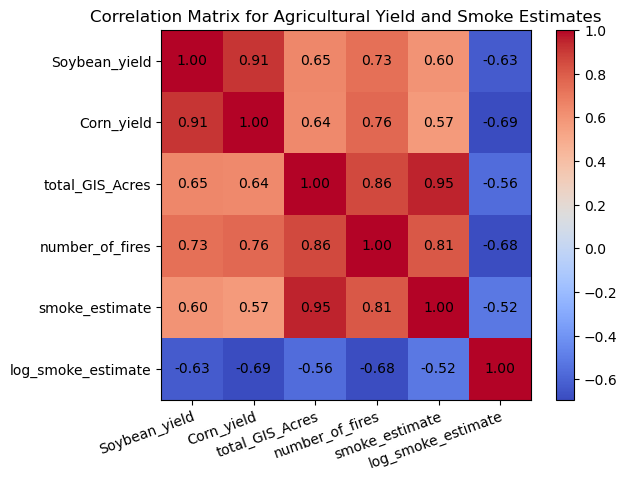

In [15]:
corr_matrix = combined_data.drop(["Year", "Fire_Year"],axis=1).corr()
# Create a figure and axes
fig, ax = plt.subplots()

# Plot the correlation matrix
im = ax.imshow(corr_matrix, cmap='coolwarm')

# Set the tick labels
ax.set_xticks(np.arange(len(corr_matrix.columns)))
ax.set_yticks(np.arange(len(corr_matrix.columns)))
ax.set_xticklabels(corr_matrix.columns)
ax.set_yticklabels(corr_matrix.columns)

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=20, ha="right",
         rotation_mode="anchor")

# Annotate each cell with the correlation coefficient value
for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        ax.text(j, i, f"{corr_matrix.iloc[i, j]:.2f}",
                ha="center", va="center", color="black")

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Show the plot
plt.title("Correlation Matrix for Agricultural Yield and Smoke Estimates")
plt.show()

In [16]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler

# Assuming your data is in a dataframe called 'df' with columns: 
# 'year', 'corn_yield', 'soybean_yield', 'smoke_estimate'

def prepare_var_model(df):
    # Create the dataset for VAR model
    model_data = pd.DataFrame({
        'corn_yield': df['Corn_yield'],
        'soybean_yield': df['Soybean_yield'],
        'smoke_estimate': df['smoke_estimate']
    })
    
    # Standardize the variables
    scaler = StandardScaler()
    model_data_scaled = pd.DataFrame(
        scaler.fit_transform(model_data),
        columns=model_data.columns,
        index=model_data.index
    )
    
    return model_data_scaled

def check_stationarity(data):
    # Check stationarity for each variable
    for column in data.columns:
        adf_test = adfuller(data[column])
        print(f'ADF Test for {column}:')
        print(f'ADF Statistic: {adf_test[0]}')
        print(f'p-value: {adf_test[1]}')

def fit_var_model(data, maxlags=5):
    # Fit VAR model
    model = VAR(data)
    
    # Select order of VAR model
    order = model.select_order(maxlags=maxlags)
    print('Optimal lag order:', order.selected_orders['aic'])
    
    # Fit the model with optimal lag
    fitted_model = model.fit(order.selected_orders['aic'])
    
    return fitted_model

def analyze_impacts(model):
    # Print Granger causality tests
    print("\nGranger Causality Tests:")
    print(model.test_causality('corn_yield', ['smoke_estimate']))
    print(model.test_causality('soybean_yield', ['smoke_estimate']))
    
    # Get impulse response functions
    irf = model.irf(periods=10)
    
    return irf

In [17]:

# Prepare data
model_data = prepare_var_model(combined_data)

# Check stationarity
check_stationarity(model_data)

# Fit model
var_model = fit_var_model(model_data)

# Analyze impacts
irf_results = analyze_impacts(var_model)

# Print summary
print(var_model.summary())

ADF Test for corn_yield:
ADF Statistic: 0.6990836570390134
p-value: 0.989819564662313
ADF Test for soybean_yield:
ADF Statistic: 1.4500742395131077
p-value: 0.9973301613808666
ADF Test for smoke_estimate:
ADF Statistic: 1.0204397939498098
p-value: 0.9944769982770322
Optimal lag order: 5

Granger Causality Tests:
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: smoke_estimate does not Granger-cause corn_yield: fail to reject at 5% significance level. Test statistic: 0.860, critical value: 2.298>, p-value: 0.510>
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: smoke_estimate does not Granger-cause soybean_yield: fail to reject at 5% significance level. Test statistic: 0.956, critical value: 2.298>, p-value: 0.448>
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 04, Dec, 2024
Time:                     21:38:51
------------------------------

### Observations:

1. ADF Results imply non-staionarity, i.e., changing trends over time, as p > 0.05
2. Granger causality implies past smoke estimate does not predict future crop yield.
3. There's no strong statistical evidence that smoke estimates significantly influence agricultural yields in Omaha


### Next: Adding Smoke Estimate as an external regressor to forecast crop yields

/var/folders/d4/_1hqbzm57hl3l9997c2d83t80000gn/T/ipykernel_29184/3438556953.py:22: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_copy['smoke_estimate'] = df_copy['smoke_estimate'].fillna(method='ffill')
/var/folders/d4/_1hqbzm57hl3l9997c2d83t80000gn/T/ipykernel_29184/3438556953.py:22: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_copy['smoke_estimate'] = df_copy['smoke_estimate'].fillna(method='ffill')
22:07:49 - cmdstanpy - INFO - Chain [1] start processing
22:07:49 - cmdstanpy - INFO - Chain [1] done processing
/opt/anaconda3/envs/geo_env/lib/python3.13/site-packages/prophet/forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


Training Corn Yield Model...


  0%|          | 0/7 [00:00<?, ?it/s]22:07:49 - cmdstanpy - INFO - Chain [1] start processing
22:07:49 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:00,  7.08it/s]22:07:49 - cmdstanpy - INFO - Chain [1] start processing
22:07:49 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:00<00:00,  8.02it/s]22:07:49 - cmdstanpy - INFO - Chain [1] start processing
22:07:49 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:00<00:00,  8.26it/s]22:07:49 - cmdstanpy - INFO - Chain [1] start processing
22:07:50 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:00<00:00,  7.97it/s]22:07:50 - cmdstanpy - INFO - Chain [1] start processing
22:07:50 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:00<00:00,  7.02it/s]22:07:50 - cmdstanpy - INFO - Chain [1] start processing
22:07:50 - cmdstanpy - INFO - Chain [1] done processing
 86%|████████▌ | 6/7 [00:00<00:00,  6.62it/s]22:07:50 - cmds


Training Soybean Yield Model...


  0%|          | 0/7 [00:00<?, ?it/s]22:07:50 - cmdstanpy - INFO - Chain [1] start processing
22:07:50 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:00<00:00,  8.01it/s]22:07:50 - cmdstanpy - INFO - Chain [1] start processing
22:07:50 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:00<00:00,  8.62it/s]22:07:50 - cmdstanpy - INFO - Chain [1] start processing
22:07:51 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 3/7 [00:00<00:00,  8.93it/s]22:07:51 - cmdstanpy - INFO - Chain [1] start processing
22:07:51 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:00<00:00,  8.08it/s]22:07:51 - cmdstanpy - INFO - Chain [1] start processing
22:07:51 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 5/7 [00:00<00:00,  8.02it/s]22:07:51 - cmdstanpy - INFO - Chain [1] start processing
22:07:51 - cmdstanpy - INFO - Chain [1] done processing
 86%|████████▌ | 6/7 [00:00<00:00,  7.72it/s]22:07:51 - cmds


Cross Validation Metrics for Corn Yield:
MAE: 23.33
RMSE: 28.09
MAPE: 0.18%

Cross Validation Metrics for Soybean Yield:
MAE: 7.07
RMSE: 8.64
MAPE: 0.18%


<Figure size 640x480 with 0 Axes>

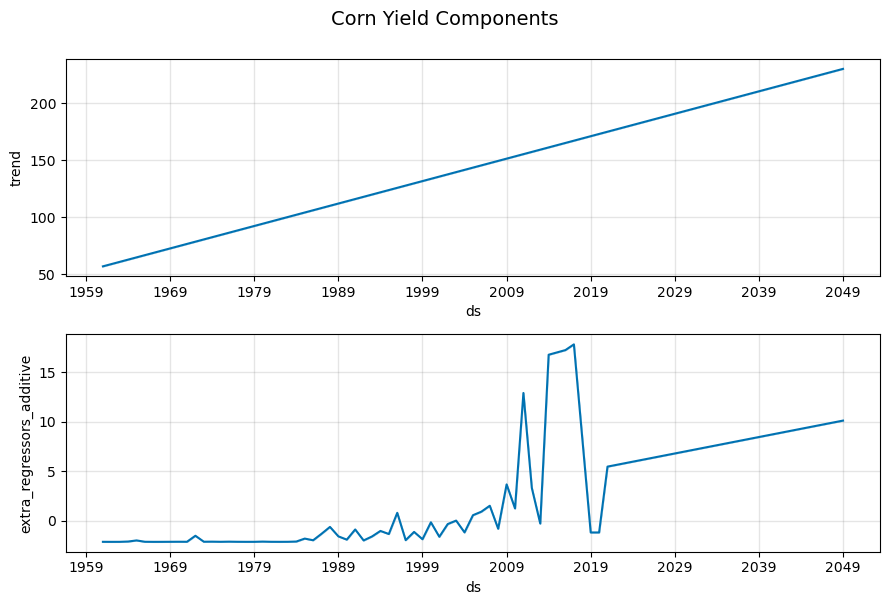

<Figure size 640x480 with 0 Axes>

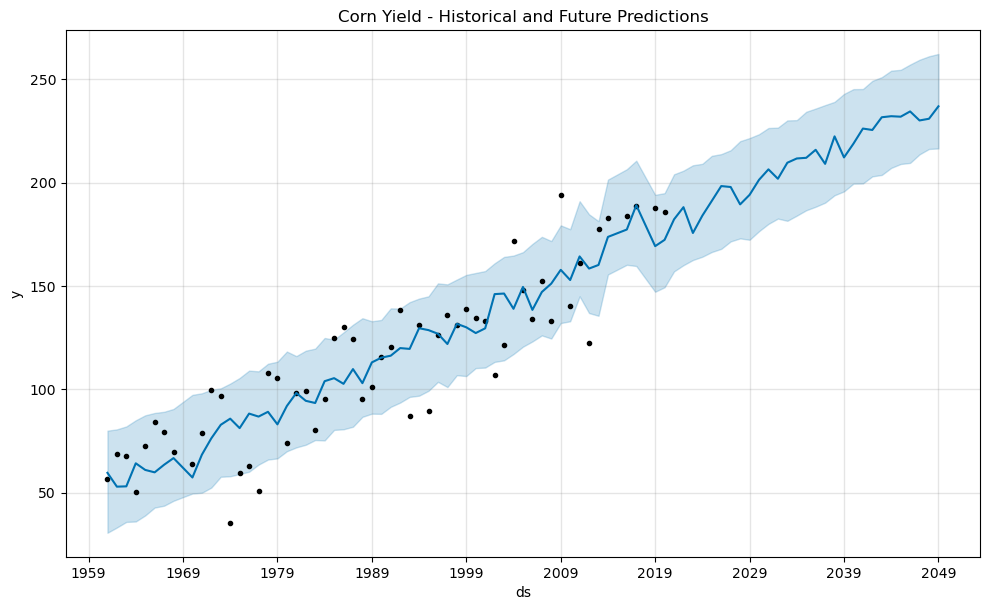

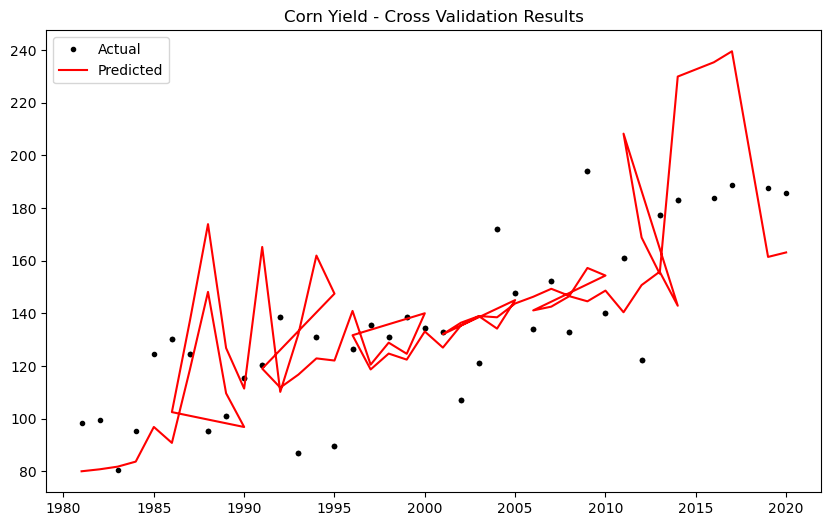

<Figure size 640x480 with 0 Axes>

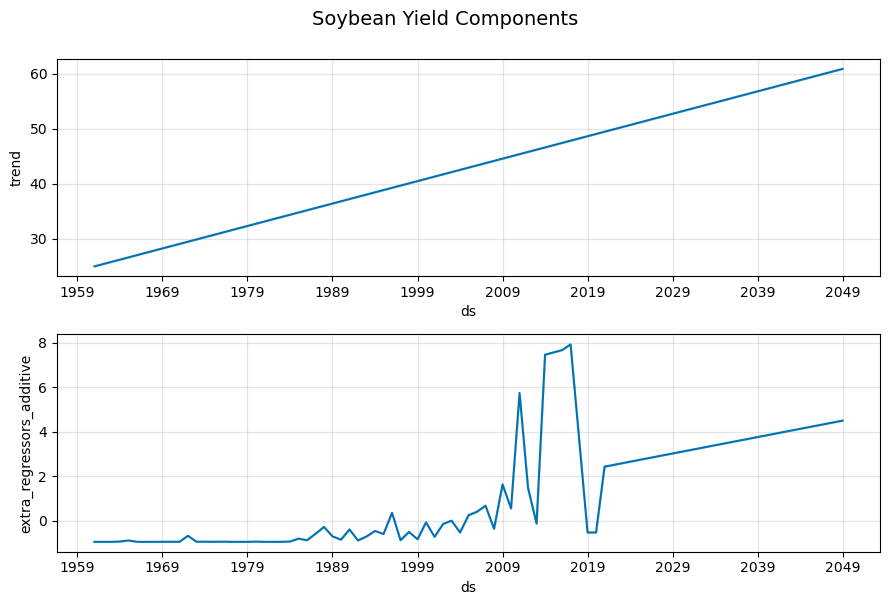

<Figure size 640x480 with 0 Axes>

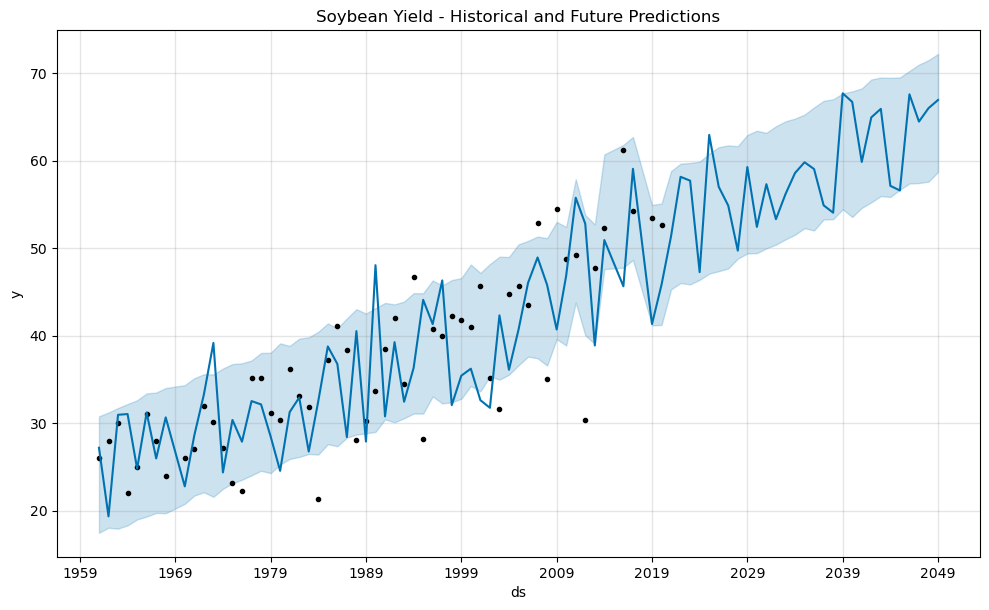

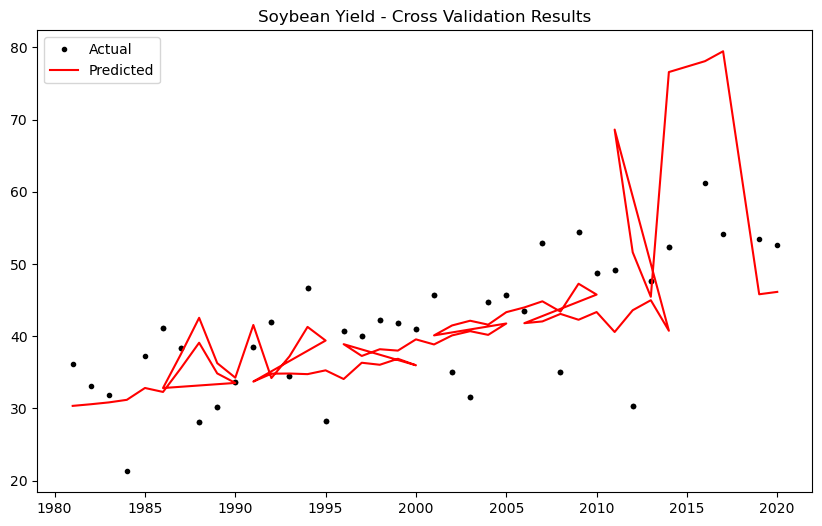

In [53]:
# Read forecasted smoke data
yearly_smoke_forecast = pd.read_csv("forecasted-smoke_estimates.csv")

# Rename columns
forecasted_smoke = yearly_smoke_forecast.rename(columns={'yhat': 'smoke'})

# Convert 'ds' to datetime format
forecasted_smoke['ds'] = pd.to_datetime(forecasted_smoke['ds'], format='%Y-%m-%d')

# Filter rows between 2021 and 2049
forecasted_smoke = forecasted_smoke[
    (forecasted_smoke['ds'].dt.year >= 2021) & (forecasted_smoke['ds'].dt.year <= 2049)
][['ds','smoke']]
forecasted_smoke['ds'] = forecasted_smoke['ds'].apply(lambda x: x.year)
forecasted_smoke.head(2)


def prepare_prophet_data(df, forecasted_smoke, crop_type='corn'):
    df_copy = df.copy()
    
    # Handle NaN values in smoke estimates
    df_copy['smoke_estimate'] = df_copy['smoke_estimate'].fillna(method='ffill')
    
    # Create Prophet dataframe
    if crop_type == 'corn':
        prophet_df = pd.DataFrame({
            'ds': pd.to_datetime(df_copy['Year'].astype(str)),
            'y': df_copy['Corn_yield']
        })
    else:
        prophet_df = pd.DataFrame({
            'ds': pd.to_datetime(df_copy['Year'].astype(str)),
            'y': df_copy['Soybean_yield']
        })
    
    # Add historical smoke estimates
    prophet_df['smoke_estimate'] = df_copy['smoke_estimate']
    
    # Scale all smoke estimates (both historical and future)
    scaler = StandardScaler()
    prophet_df['smoke_estimate_scaled'] = scaler.fit_transform(prophet_df[['smoke_estimate']])
    
    # Prepare future smoke estimates
    future_smoke = pd.DataFrame({
        'ds': pd.to_datetime(forecasted_smoke['ds'].astype(str)),
        'smoke_estimate': forecasted_smoke['smoke']
    })
    future_smoke['smoke_estimate_scaled'] = scaler.transform(future_smoke[['smoke_estimate']])
    
    return prophet_df, future_smoke

def train_prophet_model(prophet_df, future_smoke, crop_type='corn'):
    # Initialize and fit model
    model = Prophet(yearly_seasonality=False)
    model.add_regressor('smoke_estimate_scaled')
    model.fit(prophet_df)
    
    # Create future dataframe using forecasted smoke values
    future = model.make_future_dataframe(periods=len(future_smoke), freq='Y')
    future['smoke_estimate_scaled'] = pd.concat([
        prophet_df['smoke_estimate_scaled'],
        future_smoke['smoke_estimate_scaled']
    ]).values
    
    # Make predictions
    forecast = model.predict(future)

    # Add random noise to predictions
    forecast['yhat'] = forecast['yhat'] + np.random.normal(0, 5, len(forecast))  # Adjust noise level as needed
    # return forecast[['ds', 'yhat']]
    
    # Perform cross validation
    cv_results = cross_validation(
        model,
        initial='5475 days',  # About 15 years of training
        period='1825 days',   # Evaluate on 5-year periods
        horizon='3650 days'   # Forecast up to 10 years
    )
    
    # Calculate performance metrics
    metrics = performance_metrics(cv_results)
    
    return model, forecast, cv_results, metrics

def analyze_and_plot(model, forecast, cv_results, metrics, crop_type='corn'):
    # Original plots
    plt.figure()
    fig1 = model.plot_components(forecast)
    plt.suptitle(f'{crop_type.capitalize()} Yield Components', y=1, fontsize=14)
    plt.tight_layout()
    
    plt.figure()
    fig2 = model.plot(forecast)
    plt.title(f'{crop_type.capitalize()} Yield - Historical and Future Predictions')
    
    # Add cross validation plots
    fig3, ax = plt.subplots(figsize=(10, 6))
    plt.plot(cv_results['ds'], cv_results['y'], 'k.', label='Actual')
    plt.plot(cv_results['ds'], cv_results['yhat'], 'r-', label='Predicted')
    plt.title(f'{crop_type.capitalize()} Yield - Cross Validation Results')
    plt.legend()
    
    # Print performance metrics
    print(f"\nCross Validation Metrics for {crop_type.capitalize()} Yield:")
    print(f"MAE: {metrics['mae'].mean():.2f}")
    print(f"RMSE: {metrics['rmse'].mean():.2f}")
    print(f"MAPE: {metrics['mape'].mean():.2f}%")

def main_analysis(combined_data, forecasted_smoke):
    # Prepare data
    corn_df, future_smoke_corn = prepare_prophet_data(combined_data, forecasted_smoke, 'corn')
    soybean_df, future_smoke_soy = prepare_prophet_data(combined_data, forecasted_smoke, 'soybean')
    
    # Train models with cross validation
    print("Training Corn Yield Model...")
    corn_model, corn_forecast, corn_cv, corn_metrics = train_prophet_model(corn_df, future_smoke_corn, 'corn')
    
    print("\nTraining Soybean Yield Model...")
    soybean_model, soybean_forecast, soy_cv, soy_metrics = train_prophet_model(soybean_df, future_smoke_soy, 'soybean')
    
    # Analyze results
    analyze_and_plot(corn_model, corn_forecast, corn_cv, corn_metrics,  'corn')
    analyze_and_plot(soybean_model, soybean_forecast, soy_cv, soy_metrics, 'soybean')
    
    plt.show()
main_analysis(combined_data, forecasted_smoke)

### Secondary Analysis: Impact of Smoke on Crop Condition

In [58]:
corn_quality = pd.read_csv("corn-quality.csv")
soybean_quality = pd.read_csv("soybean-quality.csv")

In [59]:
q_corn_pivoted = corn_quality.sort_values(['Year', 'Period'], ascending=[True, False]).pivot(index=["Year","Period"], columns="Data Item",values='Value')

In [60]:
corn_condition = corn_quality.groupby('Year')['Period'].max().reset_index().merge(q_corn_pivoted, on=["Year","Period"]).drop("Period",axis=1)
corn_condition.fillna(0,inplace=True)

In [61]:
q_soybean_pivoted = soybean_quality.sort_values(['Year', 'Period'], ascending=[True, False]).pivot(index=["Year","Period"], columns="Data Item",values='Value')
soybean_condition = soybean_quality.groupby('Year')['Period'].max().reset_index().merge(q_soybean_pivoted, on=["Year","Period"]).drop("Period",axis=1)
soybean_condition.fillna(0,inplace=True)

In [62]:
# Calculate the sum of the condition percentages for each year
corn_condition['Total_Percentage'] = corn_condition.iloc[:, 1:].sum(axis=1)
soybean_condition['Total_Percentage'] = soybean_condition.iloc[:,1:].sum(axis=1)

# Identify years where the total is not close to 100%
# incomplete_data = corn_condition[abs(corn_condition['Total_Percentage'] - 100) > 1]
incomplete_data = soybean_condition[abs(soybean_condition['Total_Percentage'] - 100) > 1]
if not incomplete_data.empty:
    print("Warning: The following years do not sum to 100% and may need attention:")
    print(incomplete_data[['Year', 'Total_Percentage']])


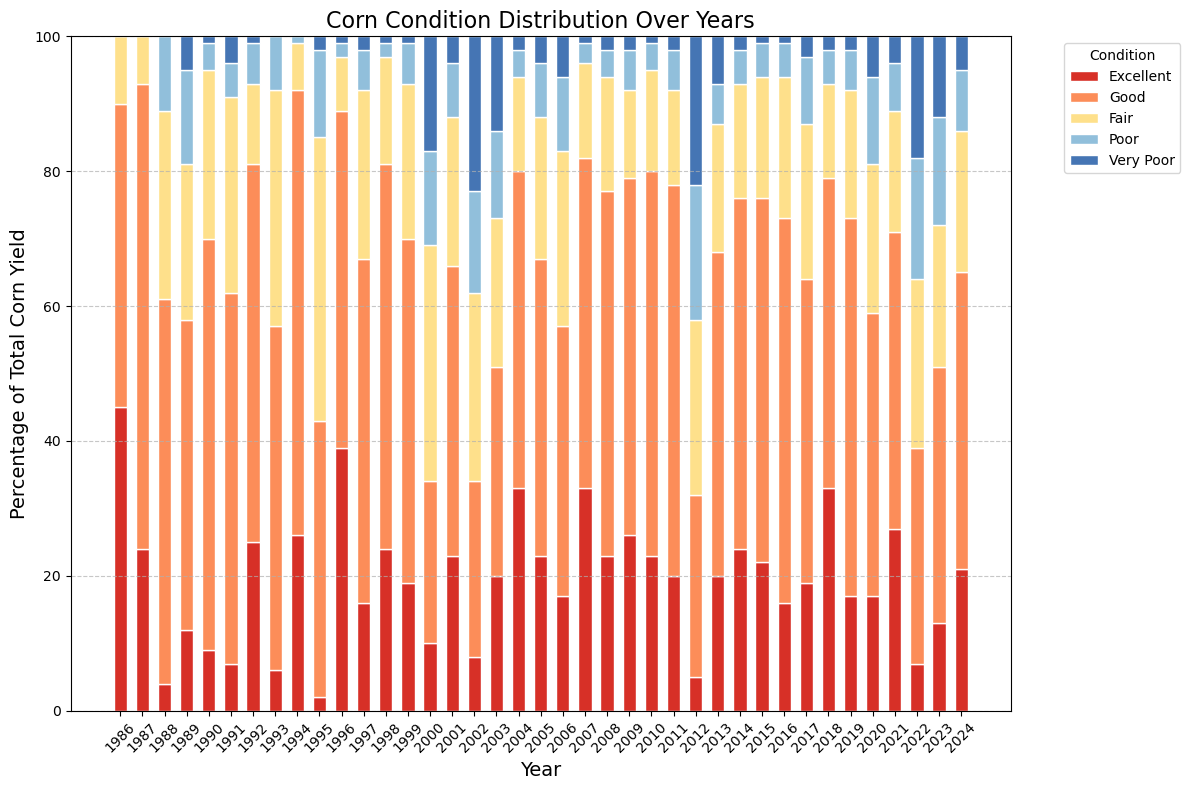

In [69]:
# Define the conditions and their corresponding colors
conditions = [
    'CORN - CONDITION, MEASURED IN PCT EXCELLENT',
    'CORN - CONDITION, MEASURED IN PCT GOOD',
    'CORN - CONDITION, MEASURED IN PCT FAIR',
    'CORN - CONDITION, MEASURED IN PCT POOR',
    'CORN - CONDITION, MEASURED IN PCT VERY POOR'
]

# Colors for each condition (from red to green)
colors = ['#d73027', '#fc8d59', '#fee08b', '#91bfdb', '#4575b4']

# Sort the DataFrame by Year
corn_condition.sort_values('Year', inplace=True)

# Set up the plot
plt.figure(figsize=(12, 8))

# Initialize the bottom position for the stacking
bottom = [0] * len(corn_condition)

# Plot each condition
for idx, condition in enumerate(conditions):
    plt.bar(
        corn_condition['Year'],
        corn_condition[condition],
        bottom=bottom,
        color=colors[idx],
        edgecolor='white',
        width=0.6,
        label=condition.split(', MEASURED IN PCT ')[-1].title()
    )
    # Update the bottom position
    bottom = [i + j for i, j in zip(bottom, corn_condition[condition])]

# Add labels and title
plt.xlabel('Year', fontsize=14)
plt.ylabel('Percentage of Total Corn Yield', fontsize=14)
plt.title('Corn Condition Distribution Over Years', fontsize=16)

# Add legend
plt.legend(title='Condition', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust x-axis ticks
plt.xticks(corn_condition['Year'], rotation=45)

# Add gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tight layout to prevent clipping
plt.tight_layout()

# Display the plot
plt.show()


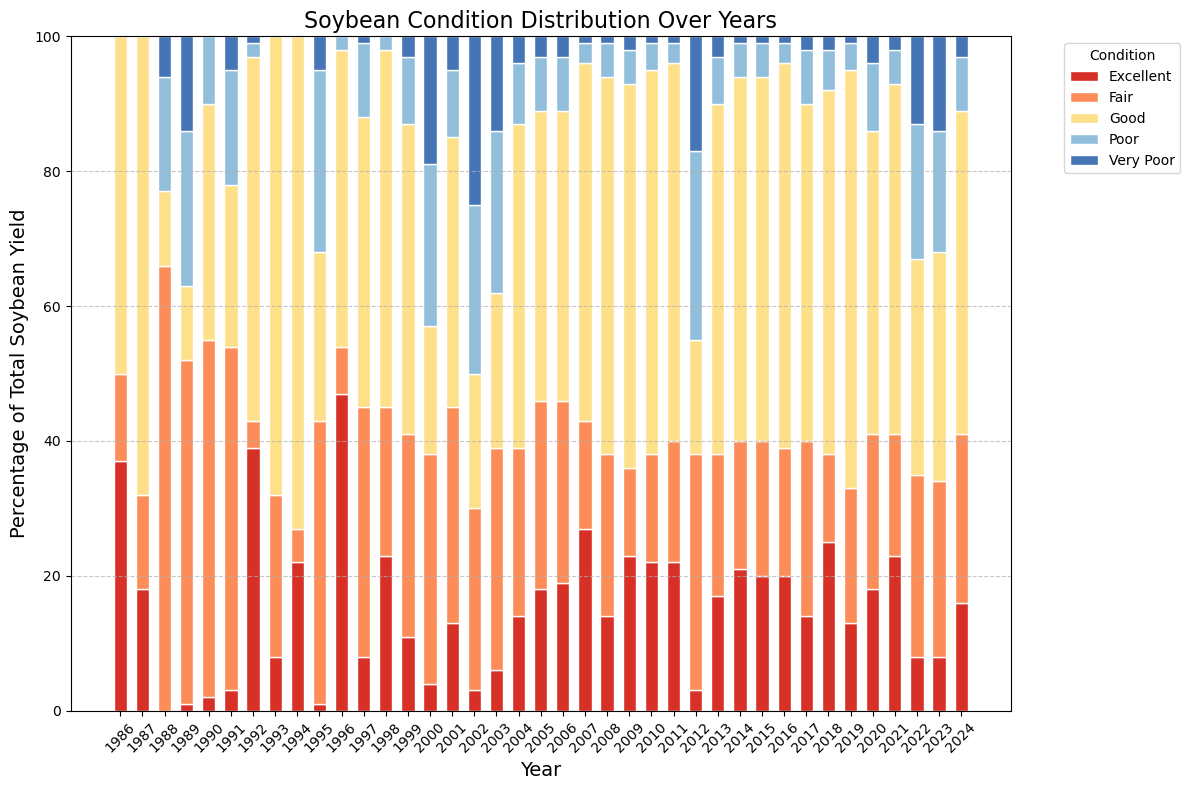

In [64]:
# Define the conditions and their corresponding colors
conditions = [
    'SOYBEANS - CONDITION, MEASURED IN PCT EXCELLENT',
       'SOYBEANS - CONDITION, MEASURED IN PCT FAIR',
       'SOYBEANS - CONDITION, MEASURED IN PCT GOOD',
       'SOYBEANS - CONDITION, MEASURED IN PCT POOR',
       'SOYBEANS - CONDITION, MEASURED IN PCT VERY POOR'
]

# Colors for each condition (from red to green)
colors = ['#d73027', '#fc8d59', '#fee08b', '#91bfdb', '#4575b4'].reverse()

# Sort the DataFrame by Year
soybean_condition.sort_values('Year', inplace=True)

# Set up the plot
plt.figure(figsize=(12, 8))

# Initialize the bottom position for the stacking
bottom = [0] * len(soybean_condition)

# Plot each condition
for idx, condition in enumerate(conditions):
    plt.bar(
        soybean_condition['Year'],
        soybean_condition[condition],
        bottom=bottom,
        color=colors[idx],
        edgecolor='white',
        width=0.6,
        label=condition.split(', MEASURED IN PCT ')[-1].title()
    )
    # Update the bottom position
    bottom = [i + j for i, j in zip(bottom, soybean_condition[condition])]

# Add labels and title
plt.xlabel('Year', fontsize=14)
plt.ylabel('Percentage of Total Soybean Yield', fontsize=14)
plt.title('Soybean Condition Distribution Over Years', fontsize=16)

# Add legend
plt.legend(title='Condition', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust x-axis ticks
plt.xticks(soybean_condition['Year'], rotation=45)

# Add gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tight layout to prevent clipping
plt.tight_layout()

# Display the plot
plt.show()


In [388]:
condition_scores = {
    'CORN - CONDITION, MEASURED IN PCT VERY POOR': 1,
    'CORN - CONDITION, MEASURED IN PCT POOR': 2,
    'CORN - CONDITION, MEASURED IN PCT FAIR': 3,
    'CORN - CONDITION, MEASURED IN PCT GOOD': 4,
    'CORN - CONDITION, MEASURED IN PCT EXCELLENT': 5
}
corn_condition['Average_Condition_Score'] = 0
for column, score in condition_scores.items():
    corn_condition['Average_Condition_Score'] += corn_condition[column] * score / 100



In [399]:
X = fiyah[fiyah['Fire_Year']>=1986].reset_index(drop=True)[['smoke_estimate']]
y = corn_condition[corn_condition['Year']<=2020]['Average_Condition_Score']

In [400]:
import statsmodels.api as sm

X = sm.add_constant(X)


In [401]:
model = sm.OLS(y, X).fit()


In [402]:
print(model.summary())


                               OLS Regression Results                              
Dep. Variable:     Average_Condition_Score   R-squared:                       0.007
Model:                                 OLS   Adj. R-squared:                 -0.023
Method:                      Least Squares   F-statistic:                    0.2202
Date:                     Wed, 27 Nov 2024   Prob (F-statistic):              0.642
Time:                             22:30:27   Log-Likelihood:                -14.963
No. Observations:                       35   AIC:                             33.93
Df Residuals:                           33   BIC:                             37.04
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

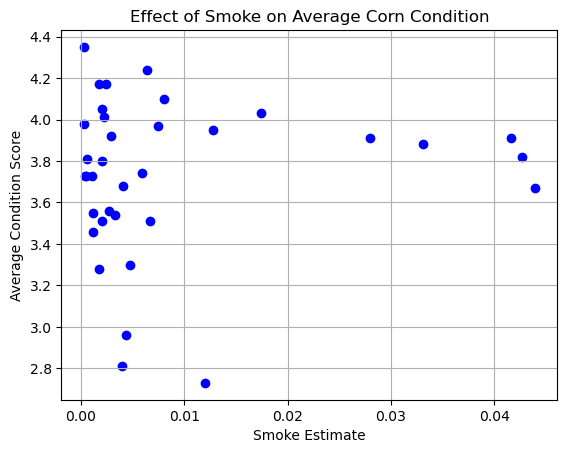

In [404]:
plt.scatter(X['smoke_estimate'], y, color='blue')
plt.xlabel('Smoke Estimate')
plt.ylabel('Average Condition Score')
plt.title('Effect of Smoke on Average Corn Condition')
plt.grid(True)
plt.show()


In [406]:
from statsmodels.stats.stattools import durbin_watson

# Define the dependent and independent variables
X = combined_data[['smoke_estimate']]
X = sm.add_constant(X)  # Adds the intercept term
y_corn = combined_data['Corn_yield']
y_soybean = combined_data['Soybean_yield']

# Fit the model for corn yield
model_corn = sm.OLS(y_corn, X).fit(cov_type='HAC', cov_kwds={'maxlags':1})

# Fit the model for soybean yield
model_soybean = sm.OLS(y_soybean, X).fit(cov_type='HAC', cov_kwds={'maxlags':1})

# Print the summary of the regression
print("Corn Yield Model Summary:")
print(model_corn.summary())

print("\nSoybean Yield Model Summary:")
print(model_soybean.summary())

# Check for autocorrelation using Durbin-Watson test
dw_corn = durbin_watson(model_corn.resid)
dw_soybean = durbin_watson(model_soybean.resid)

print(f"\nDurbin-Watson statistic for corn yield residuals: {dw_corn}")
print(f"Durbin-Watson statistic for soybean yield residuals: {dw_soybean}")


Corn Yield Model Summary:
                            OLS Regression Results                            
Dep. Variable:             Corn_yield   R-squared:                       0.329
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     52.72
Date:                Wed, 27 Nov 2024   Prob (F-statistic):           1.41e-09
Time:                        22:36:45   Log-Likelihood:                -280.21
No. Observations:                  57   AIC:                             564.4
Df Residuals:                      55   BIC:                             568.5
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            1

In [42]:
forecasted_smoke.rename(columns={'Year':"year","smoke":"smoke_estimate"},inplace=True)

In [489]:
condition_df = corn_condition.merge(combined_data, on='Year').merge(soybean_condition,on='Year')

In [490]:
condition_df.columns

Index(['Year', 'CORN - CONDITION, MEASURED IN PCT EXCELLENT',
       'CORN - CONDITION, MEASURED IN PCT FAIR',
       'CORN - CONDITION, MEASURED IN PCT GOOD',
       'CORN - CONDITION, MEASURED IN PCT POOR',
       'CORN - CONDITION, MEASURED IN PCT VERY POOR', 'Total_Percentage_x',
       'Average_Condition_Score', 'Soybean_yield', 'Corn_yield', 'Fire_Year',
       'total_GIS_Acres', 'number_of_fires', 'smoke_estimate',
       'log_smoke_estimate', 'SOYBEANS - CONDITION, MEASURED IN PCT EXCELLENT',
       'SOYBEANS - CONDITION, MEASURED IN PCT FAIR',
       'SOYBEANS - CONDITION, MEASURED IN PCT GOOD',
       'SOYBEANS - CONDITION, MEASURED IN PCT POOR',
       'SOYBEANS - CONDITION, MEASURED IN PCT VERY POOR',
       'Total_Percentage_y'],
      dtype='object')

Processing Corn Conditions...
Optimization terminated successfully.
         Current function value: 0.244834
         Iterations: 277
         Function evaluations: 460

Ordinal Logistic Regression Results for Corn:
                             OrderedModel Results                             
Dep. Variable:     condition_category   Log-Likelihood:                -7.5899
Model:                   OrderedModel   AIC:                             23.18
Method:            Maximum Likelihood   BIC:                             28.92
Date:                Thu, 28 Nov 2024                                         
Time:                        01:22:40                                         
No. Observations:                  31                                         
Df Residuals:                      27                                         
Df Model:                           3                                         
                            coef    std err          z      P>|z|      [

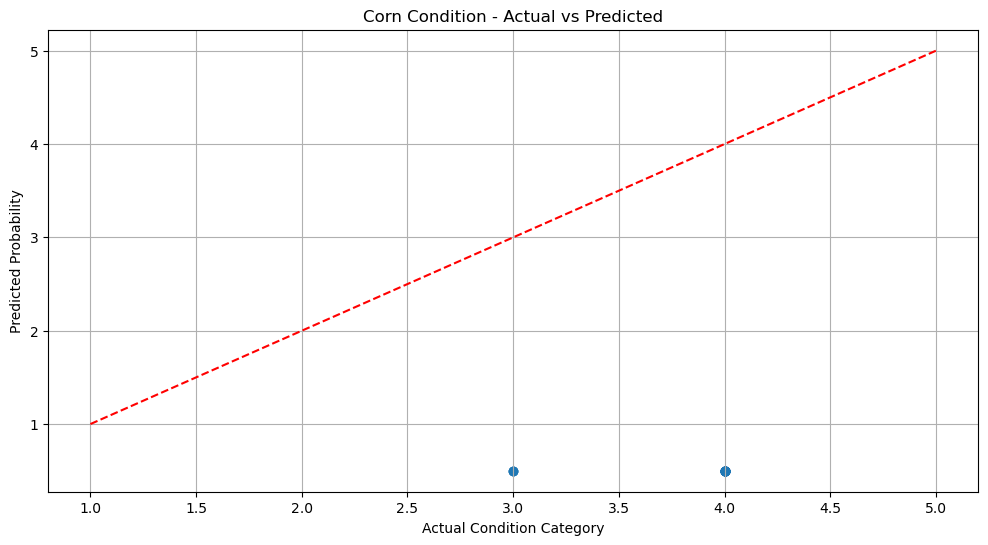

<Figure size 1200x600 with 0 Axes>

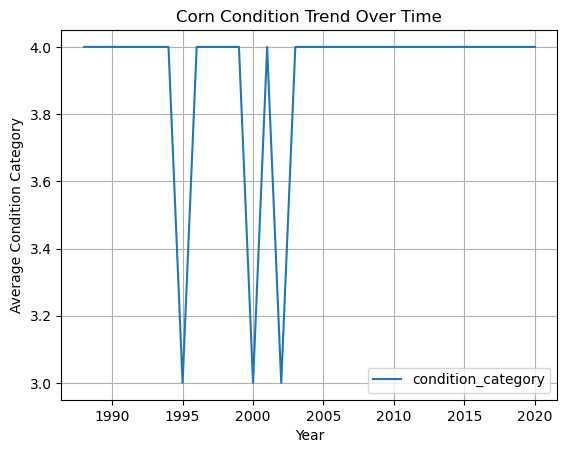

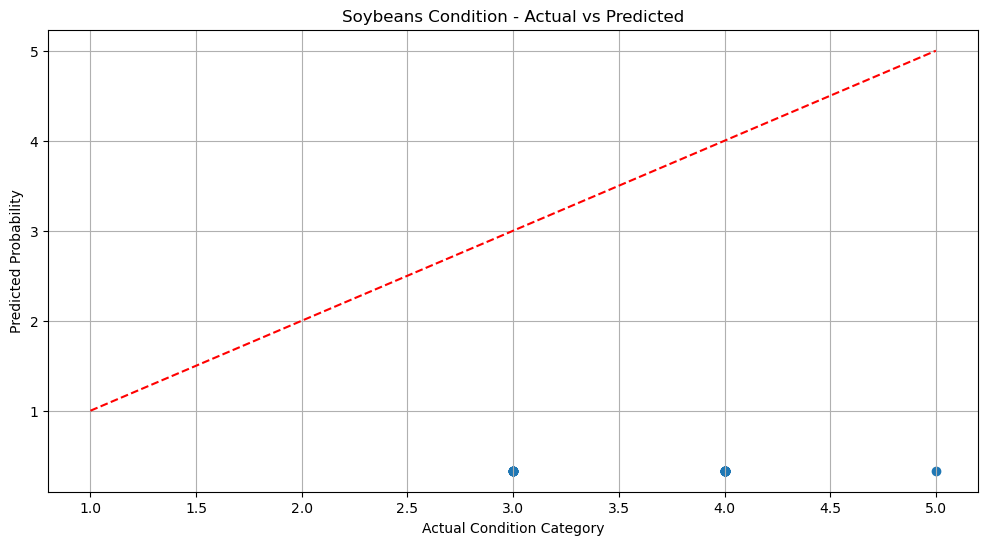

<Figure size 1200x600 with 0 Axes>

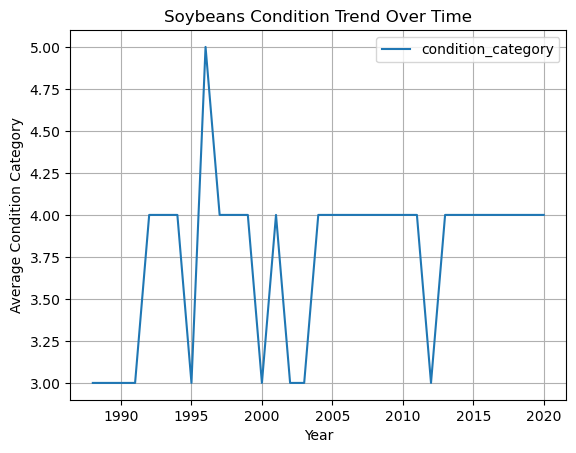

In [496]:
import pandas as pd
import numpy as np
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def prepare_condition_data(df, crop_type='corn'):
    """Prepare data for ordinal logistic regression"""
    
    # Create copy to avoid modifying original
    df_copy = df.copy()
    
    # Select relevant condition columns based on crop type
    if crop_type.lower() == 'corn':
        condition_cols = [col for col in df.columns if 'CORN - CONDITION' in col]
    else:
        condition_cols = [col for col in df.columns if 'SOYBEANS - CONDITION' in col]
    
    # Calculate weighted condition score (1=Very Poor to 5=Excellent)
    df_copy['weighted_condition'] = (
        df_copy[f'{crop_type.upper()} - CONDITION, MEASURED IN PCT EXCELLENT'] * 5 +
        df_copy[f'{crop_type.upper()} - CONDITION, MEASURED IN PCT GOOD'] * 4 +
        df_copy[f'{crop_type.upper()} - CONDITION, MEASURED IN PCT FAIR'] * 3 +
        df_copy[f'{crop_type.upper()} - CONDITION, MEASURED IN PCT POOR'] * 2 +
        df_copy[f'{crop_type.upper()} - CONDITION, MEASURED IN PCT VERY POOR'] * 1
    ) / 100

    # Create categorical condition based on highest percentage
    df_copy['dominant_condition'] = df_copy[condition_cols].idxmax(axis=1)
    
    # Map to numeric categories
    condition_map = {
        f'{crop_type.upper()} - CONDITION, MEASURED IN PCT VERY POOR': 1,
        f'{crop_type.upper()} - CONDITION, MEASURED IN PCT POOR': 2,
        f'{crop_type.upper()} - CONDITION, MEASURED IN PCT FAIR': 3,
        f'{crop_type.upper()} - CONDITION, MEASURED IN PCT GOOD': 4,
        f'{crop_type.upper()} - CONDITION, MEASURED IN PCT EXCELLENT': 5
    }
    df_copy['condition_category'] = df_copy['dominant_condition'].map(condition_map)
    
    # Prepare smoke variables
    scaler = StandardScaler()
    df_copy['smoke_estimate_scaled'] = scaler.fit_transform(df_copy[['smoke_estimate']])
    # df_copy['log_smoke_scaled'] = scaler.fit_transform(df_copy[['log_smoke_estimate']])
    
    # Create lagged variables
    df_copy['smoke_lag1'] = df_copy['smoke_estimate_scaled'].shift(1)
    df_copy['smoke_lag2'] = df_copy['smoke_estimate_scaled'].shift(2)
    
    return df_copy.dropna()

def fit_ordinal_model(data, crop_type='corn'):
    """Fit ordinal logistic regression model"""
    
    # Prepare predictor variables
    X = data[['smoke_estimate_scaled', 'smoke_lag1', 'smoke_lag2']]
    y = data['condition_category']
    
    # Fit model
    model = OrderedModel(y, X, distr='logit')
    results = model.fit()
    
    return results

def analyze_results(results, data, crop_type='corn'):
    """Analyze and visualize model results"""
    
    # Print model summary
    print(f"\nOrdinal Logistic Regression Results for {crop_type.capitalize()}:")
    print(results.summary())
    
    # Calculate predicted probabilities
    pred_probs = results.predict()
    
    # Plot actual vs predicted categories
    plt.figure(figsize=(12, 6))
    plt.scatter(data['condition_category'], pred_probs.mean(axis=1))
    plt.plot([1, 5], [1, 5], 'r--')  # Add diagonal reference line
    plt.xlabel('Actual Condition Category')
    plt.ylabel('Predicted Probability')
    plt.title(f'{crop_type.capitalize()} Condition - Actual vs Predicted')
    plt.grid(True)
    
    # Plot condition distributions over time
    plt.figure(figsize=(12, 6))
    data.groupby('Year')[['condition_category']].mean().plot()
    plt.title(f'{crop_type.capitalize()} Condition Trend Over Time')
    plt.xlabel('Year')
    plt.ylabel('Average Condition Category')
    plt.grid(True)
    
    return pred_probs


def main_analysis(condition_df):
    # Analyze corn conditions
    print("Processing Corn Conditions...")
    corn_data = prepare_condition_data(condition_df, 'corn')
    corn_model = fit_ordinal_model(corn_data, 'corn')
    corn_predictions= analyze_results(corn_model, corn_data, 'corn')
    
    # Analyze soybean conditions
    print("\nProcessing Soybean Conditions...")
    soy_data = prepare_condition_data(condition_df, 'soybeans')
    soy_model = fit_ordinal_model(soy_data, 'soybeans')
    soy_predictions= analyze_results(soy_model, soy_data, 'soybeans')
    
    plt.show()
    
    return {
        'corn': {'data': corn_data, 'model': corn_model, 
                'predictions': corn_predictions},
        'soy': {'data': soy_data, 'model': soy_model, 
                'predictions': soy_predictions}
    }

# Run the analysis
results = main_analysis(condition_df)

17:42:22 - cmdstanpy - INFO - Chain [1] start processing
17:42:22 - cmdstanpy - INFO - Chain [1] done processing
/opt/anaconda3/envs/geo_env/lib/python3.13/site-packages/prophet/forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


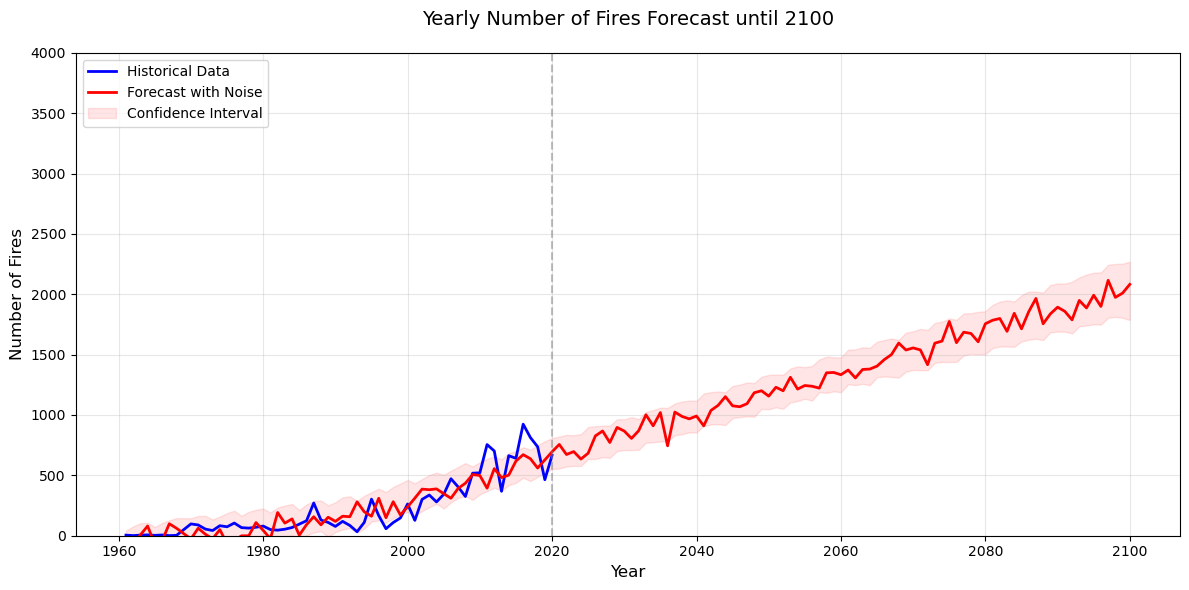

In [27]:
# Convert the data to Prophet format
df = fiyah[['Fire_Year', 'number_of_fires']].rename(columns={'Fire_Year': 'ds', 'number_of_fires': 'y'})
df['ds'] = pd.to_datetime(df['ds'], format='%Y')

# Create and fit the Prophet model
model = Prophet(yearly_seasonality=True)
model.fit(df)

# Create future dates (yearly instead of monthly)
future_periods = 2100 - df['ds'].dt.year.max()
future = model.make_future_dataframe(periods=future_periods, freq='Y')

# Generate forecast
forecast = model.predict(future)

# Add random noise
np.random.seed(42)
noise = np.random.normal(0, forecast['yhat'].std() * 0.1, size=len(forecast))
forecast['yhat_with_noise'] = forecast['yhat'] + noise

# Plot with improvements
plt.figure(figsize=(12, 6))
plt.plot(df['ds'], df['y'], label='Historical Data', color='blue', linewidth=2)
plt.plot(forecast['ds'], forecast['yhat_with_noise'], 
         label='Forecast with Noise', color='red', linewidth=2)
plt.fill_between(forecast['ds'], 
                 forecast['yhat_lower'], 
                 forecast['yhat_upper'], 
                 color='red', 
                 alpha=0.1,
                 label='Confidence Interval')

# Enhance the plot
plt.ylim(0, 4000)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Fires', fontsize=12)
plt.title('Yearly Number of Fires Forecast until 2100', fontsize=14, pad=20)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10, loc='upper left')

# Add vertical line to separate historical and forecast
current_year = df['ds'].max()
plt.axvline(x=current_year, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()